In [1]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

from dscribe.descriptors import CoulombMatrix
import glob
import numpy as np
import pandas as pd
from ase import io

#### 生成描述的函数

In [8]:
def GetRdkitDescriptorsFromFiles(input_dir:str, csv_file:str):
    # 准备描述符计算器
    sdf_files = [f for f in os.listdir(input_dir) if f.endswith('.sdf')]
    descs = [desc_name[0] for desc_name in Descriptors._descList]
    desc_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descs)  

    # 初始化DataFrame存储所有分子描述符
    all_descriptors = []

    # 用于检测重复的分子
    smiles_dict = {}
    for i, sdf_file in enumerate(sdf_files):
        # 获取完整的文件路径
        file_path = os.path.join(input_dir, sdf_file)
    #     print(sdf_file)
        try:
            # 读取SDF文件中的分子
            suppl = Chem.SDMolSupplier(file_path)
            mols = [mol for mol in suppl if mol is not None]

            # 检查是否有多个分子
            if len(mols) > 1:
                print(f"Warning: {sdf_file} contains multiple molecules. Skipping...")
                continue

            # 如果文件中有没有有效分子
            if not mols:
                print(f"Warning: No valid molecules found in {sdf_file}")
                continue

            mol = mols[0]  # 获取第一个分子（每个SDF文件最多一个分子）
            smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)   # 保留分子手性，并生成规范化的SMILES

            # 检查分子重复
            if smiles in smiles_dict:
                print(f"Warning: Duplicate molecule found in {sdf_file}. "
                      f"SMILES: {smiles} is already present in {smiles_dict[smiles]}. Skipping...")
                '''已经知道239与203的分子结构重复，因此取消continue，继续保存分子239的数据'''
#                 continue  
            # 记录分子SMILES和文件名
            smiles_dict[smiles] = sdf_file


            # 计算分子描述符
            descriptors = desc_calc.CalcDescriptors(mol)
            num_atoms_total = mol.GetNumAtoms(onlyExplicit=False)  # 计算包括隐式氢的原子总数
            num_atoms_heavy = mol.GetNumAtoms(onlyExplicit=True) # 计算只包括非氢原子的总数
            descriptor_data = [sdf_file, smiles, num_atoms_total, num_atoms_heavy] + list(descriptors)
            all_descriptors.append(descriptor_data)
    #         print(all_descriptors)
    #         break

        except Exception as e:
            print(f"Error processing {sdf_file}: {e}")
            continue

    # print(smiles_dict)
    # print(all_descriptors)

    # 转换为DataFrame
    columns = ['Filename', 'SMILES', 'NumAtomsTotal', 'NumAtomsHeavy'] + descs
    df = pd.DataFrame(all_descriptors, columns=columns)
    # 保存到CSV文件
    # df.to_csv(csv_file, index=False)
    return df

#### 调用函数生成PS的描述符

In [5]:
# ps_input_dir = r'C:\Users\xiaoyu\Desktop\click\molecule_Structure_ChemDraw\ps_sdf_files'
# sdf_files = [f for f in os.listdir(ps_input_dir) if f.endswith('.sdf')]
# for i, sdf_file in enumerate(sdf_files):
#     file_path = os.path.join(ps_input_dir, sdf_file)
# #     print(file_path)   # 有239

In [6]:
ps_input_dir = r'data\ps_sdf_files'
ps_X = GetRdkitDescriptorsFromFiles(ps_input_dir, None)
ps_X

,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,ps1.sdf,CC(=O)C(C)=O,12,6,9.793981,-0.379630,9.793981,0.379630,0.425942,86.090,...,0,0,0,0,0,0,0,0,0,0
1,ps10.sdf,O=CC(=O)O,7,5,9.000000,-1.425926,9.000000,0.166667,0.329268,74.035,...,0,0,0,0,0,0,0,0,0,0
2,ps100.sdf,c1ccc(-c2c3nc(c(-c4ccccc4)c4ccc([nH]4)c(-c4ccc...,82,48,5.471890,0.860213,5.471890,0.860213,0.206194,618.784,...,0,0,0,0,0,0,0,0,0,0
3,ps101.sdf,CCCCCCCCCC(=O)Oc1cc2[nH]c(cc2CCOC)c2nc(ccc3[nH...,108,52,13.528931,-0.263008,13.528931,0.263008,0.083028,712.932,...,0,0,0,0,0,0,0,0,5,0
4,ps102.sdf,CCCC1=Cc2nc1ccc1[nH]c(cc1CCC)c1nc(c(OC(C)=O)cc...,80,40,12.305435,-0.360599,12.305435,0.360599,0.267622,536.720,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,ps95.sdf,COCCC1=Cc2nc1ccc1[nH]c(cc1CCOC)c1nc(ccc3[nH]c2...,78,40,5.399421,0.630645,5.399421,0.630645,0.298361,542.680,...,0,0,0,0,0,0,0,0,0,0
246,ps96.sdf,COCCC1=Cc2nc1ccc1[nH]c(cc1CCOC)c1nc(c(OC(C)=O)...,84,44,12.394442,-0.432969,12.394442,0.358550,0.237318,600.716,...,0,0,0,0,0,0,0,0,0,0
247,ps97.sdf,CCCCCCc1cc2[nH]c(cc2CCOC)c2nc(ccc3[nH]c(cc3CCO...,96,46,5.549008,0.632025,5.549008,0.632025,0.147677,626.842,...,0,0,0,0,0,0,0,0,2,0
248,ps98.sdf,CCCCCCC(=O)Oc1cc2[nH]c(cc2CCOC)c2nc(ccc3[nH]c(...,99,49,13.356895,-0.274540,13.356895,0.274540,0.104279,670.851,...,0,0,0,0,0,0,0,0,2,0


#### 获取ps目标属性数据,缺少167和119号分子. 167号是因为用的acceptor的167号文件计算的(erro_kk，因此一直没数据)。119号是与118号分子重复计算，需要删除119，并重新计算。

In [7]:
ps_Y_path = r'data\output_ps-dataset.csv'
# ps_Y = pd.read_csv(ps_Y_path, sep="\t", encoding="utf-8")
ps_Y_data = pd.read_csv(ps_Y_path, encoding='GB2312')
# ps_Y = ps_Y_data.drop(columns=['Unnamed: 7', 'label'])  # 删除某列
ps_Y =  ps_Y_data[['id', 'lifetime']]
ps_Y

,id,lifetime
0,1,0.009525
1,2,0.001015
2,3,0.027435
3,4,0.001420
4,5,0.000101
...,...,...
181,246,13.090719
182,247,0.271518
183,248,1.617338
184,249,1.699813


In [8]:
ps_Y = ps_Y.copy()
ps_Y['Filename'] = 'ps' + ps_Y['id'].astype(str) + '.sdf'
ps_Y

,id,lifetime,Filename
0,1,0.009525,ps1.sdf
1,2,0.001015,ps2.sdf
2,3,0.027435,ps3.sdf
3,4,0.001420,ps4.sdf
4,5,0.000101,ps5.sdf
...,...,...,...
181,246,13.090719,ps246.sdf
182,247,0.271518,ps247.sdf
183,248,1.617338,ps248.sdf
184,249,1.699813,ps249.sdf


#### 合并 ps_Y 和 ps_X，保留 ps_X 中仅存在于 ps_Y 中的分子编号

In [9]:
# 合并 ps_Y 和 ps_X，保留 ps_X 中仅存在于 ps_Y 中的分子编号
ps_merged_df = pd.merge(ps_Y, ps_X, on='Filename', how='inner')
ps_merged_df

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,12,6,9.793981,-0.379630,9.793981,0.379630,...,0,0,0,0,0,0,0,0,0,0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,24,20,11.997107,-0.021721,11.997107,0.021721,...,0,0,0,0,0,0,0,0,0,0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,22,12,10.377891,0.571389,10.377891,0.571389,...,0,0,0,0,0,0,0,0,0,0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,24,16,12.101296,-0.064074,12.101296,0.064074,...,0,0,0,0,0,0,0,0,0,0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,21,11,10.945093,0.030046,10.945093,0.030046,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,246,13.090719,ps246.sdf,CC1(C)c2ccccc2Nc2ccccc21,31,16,3.496088,0.081782,3.496088,0.081782,...,0,0,0,0,0,0,0,0,0,0
182,247,0.271518,ps247.sdf,c1ccc(C2(c3ccccc3)c3ccccc3Nc3ccccc32)cc1,45,26,3.634752,-0.332384,3.634752,0.332384,...,0,0,0,0,0,0,0,0,0,0
183,248,1.617338,ps248.sdf,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2-c2ccccc21,43,26,3.653270,-0.258310,3.653270,0.258310,...,0,0,0,0,0,0,0,0,0,0
184,249,1.699813,ps249.sdf,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2Oc2ccccc21,44,27,6.314616,-0.398935,6.314616,0.398935,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data_247 = ps_X[ps_X['Filename'] == 'ps247.sdf']  # 显示ps247.sdf的描述符所在行
data_247

,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
164,ps247.sdf,c1ccc(C2(c3ccccc3)c3ccccc3Nc3ccccc32)cc1,45,26,3.634752,-0.332384,3.634752,0.332384,0.409816,333.434,...,0,0,0,0,0,0,0,0,0,0


In [11]:
a  = 'ps' + ps_Y['id'].astype(str) + '.sdf'
# a.values == merged_df['Filename'].values

In [12]:
# 检查每列的和是否为0
cols_to_drop = ps_merged_df.columns[(ps_merged_df.sum() == 0)]
cols_to_drop, len(cols_to_drop)

(Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_C_S', 'fr_HOCCN',
        'fr_N_O', 'fr_Ndealkylation2', 'fr_SH', 'fr_alkyl_carbamate',
        'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo',
        'fr_dihydropyridine', 'fr_epoxide', 'fr_furan', 'fr_guanido',
        'fr_hdrzine', 'fr_hdrzone', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam',
        'fr_morpholine', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_phos_acid',
        'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide',
        'fr_prisulfonamd', 'fr_pyridine', 'fr_sulfide', 'fr_sulfone',
        'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan',
        'fr_urea'],
       dtype='object'),
 41)

In [13]:
# 删除全0的列
ps_merged_df.drop(cols_to_drop, axis=1, inplace=True)
ps_merged_df

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_quatN,fr_sulfonamd,fr_thiophene,fr_unbrch_alkane
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,12,6,9.793981,-0.379630,9.793981,0.379630,...,0,0,0,0,0,0,0,0,0,0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,24,20,11.997107,-0.021721,11.997107,0.021721,...,0,0,0,0,1,1,0,0,0,0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,22,12,10.377891,0.571389,10.377891,0.571389,...,0,0,0,0,0,0,0,0,0,0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,24,16,12.101296,-0.064074,12.101296,0.064074,...,0,0,0,0,0,0,0,0,0,0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,21,11,10.945093,0.030046,10.945093,0.030046,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,246,13.090719,ps246.sdf,CC1(C)c2ccccc2Nc2ccccc21,31,16,3.496088,0.081782,3.496088,0.081782,...,0,0,0,2,0,0,0,0,0,0
182,247,0.271518,ps247.sdf,c1ccc(C2(c3ccccc3)c3ccccc3Nc3ccccc32)cc1,45,26,3.634752,-0.332384,3.634752,0.332384,...,0,0,0,2,0,0,0,0,0,0
183,248,1.617338,ps248.sdf,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2-c2ccccc21,43,26,3.653270,-0.258310,3.653270,0.258310,...,0,0,0,2,0,0,0,0,0,0
184,249,1.699813,ps249.sdf,c1ccc2c(c1)Nc1ccccc1C21c2ccccc2Oc2ccccc21,44,27,6.314616,-0.398935,6.314616,0.398935,...,0,0,0,4,0,0,0,0,0,0


In [14]:
# 保存合并的ps描述符和ps属性
csv_file = os.path.join(ps_input_dir, 'ps_merge_df.csv')
ps_merged_df.to_csv(csv_file, index=False)

#### 对分子的原子数分布进行可视化

In [15]:
ps_merged_df['NumAtomsTotal'].value_counts().sort_index()   # 38 出现了7次  第一列是原子数，第二列是该原子数出现的次数

7      1
10     1
11     1
12     1
15     1
      ..
109    1
114    1
126    1
128    1
134    1
Name: NumAtomsTotal, Length: 86, dtype: int64

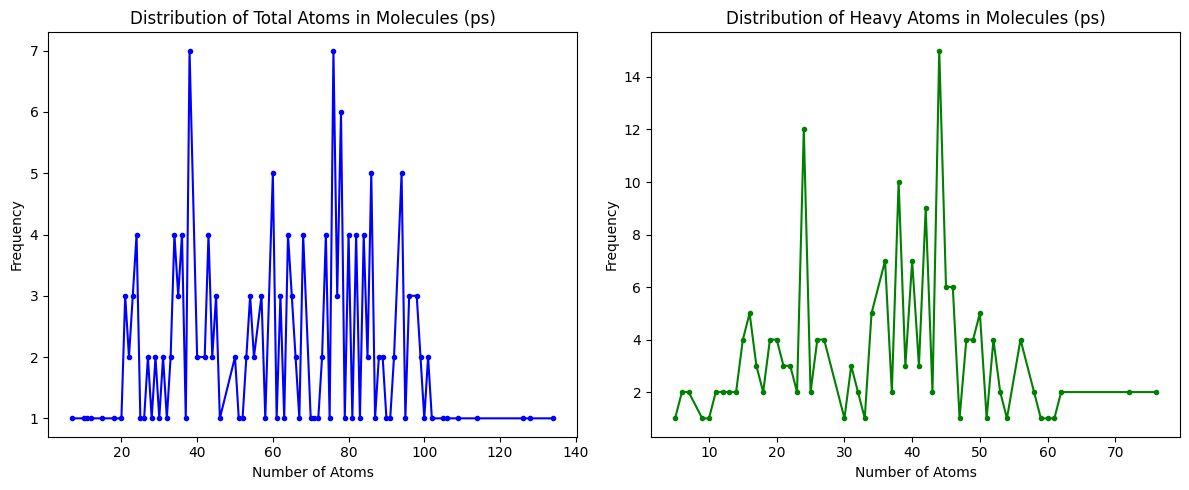

In [16]:
ps_total_atoms_counts = ps_merged_df['NumAtomsTotal'].value_counts().sort_index()
ps_heavy_atoms_counts = ps_merged_df['NumAtomsHeavy'].value_counts().sort_index()

# 绘制折线图
plt.figure(figsize=(12, 5))  # 创建一个新图形，并设置尺寸

# 第一个子图：包含所有原子的数量分布
plt.subplot(1, 2, 1)  
plt.plot(ps_total_atoms_counts.index, ps_total_atoms_counts.values, marker='o', linestyle='-', color='b', markersize=3)
plt.title('Distribution of Total Atoms in Molecules (ps)')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')

# 第二个子图：仅包含非氢原子的数量分布
plt.subplot(1, 2, 2)
plt.plot(ps_heavy_atoms_counts.index, ps_heavy_atoms_counts.values, marker='o', linestyle='-', color='g', markersize=3)
plt.title('Distribution of Heavy Atoms in Molecules (ps)')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')

plt.tight_layout()  # 自动调整子图参数，使它们不重叠
plt.show()  # 显示图形

In [17]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.hist(merged_df['NumAtomsTotal'], bins=range(min(merged_df['NumAtomsTotal']), max(merged_df['NumAtomsTotal'])+1))
# plt.title('Distribution of Total Atoms in Molecules (ps)')
# plt.xlabel('Number of Atoms')
# plt.ylabel('Frequency')
# # plt.show()

# plt.subplot(1, 2, 2)
# plt.hist(merged_df['NumAtomsHeavy'], bins=range(min(merged_df['NumAtomsHeavy']), max(merged_df['NumAtomsHeavy'])+1))
# plt.title('Distribution of Heavy Atoms in Molecules (ps)')
# plt.xlabel('Number of Atoms')
# plt.ylabel('Frequency')


# plt.tight_layout()  # 自动调整子图参数，使它们不重叠
# plt.show()  # 显示图形

## 开始进行acceptor的描述符和属性值合并处理

In [18]:
'''199号200号分子SDF文件，无法被rdkit正确读取'''
acceptor_input_dir = r'data\acceptor_sdf_files'
acceptor_X = GetRdkitDescriptorsFromFiles(acceptor_input_dir, None)
acceptor_X  

,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,acceptor1.sdf,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,70,42,2.301291,1.226653,2.301291,1.226653,0.197753,532.686,...,0,0,0,0,0,0,0,0,0,0
1,acceptor10.sdf,CCCCOC(=O)c1cccc(-c2ccc(-c3cccc(C(=O)OCCCC)c3)...,62,32,12.252059,-0.292076,12.252059,0.292076,0.258314,430.544,...,0,0,0,0,0,0,0,0,2,0
2,acceptor100.sdf,CCOC(=O)c1ccc2ccccc2c1,27,15,11.466142,-0.260877,11.466142,0.260877,0.696372,200.237,...,0,0,0,0,0,0,0,0,0,0
3,acceptor101.sdf,COC(=O)Cc1cccc2ccccc12,27,15,11.202673,-0.202451,11.202673,0.202451,0.696248,200.237,...,0,0,0,0,0,0,0,0,0,0
4,acceptor102.sdf,COC(=O)c1ccc2cc(C(=O)OC)ccc2c1,30,18,11.382266,-0.380607,11.382266,0.380607,0.761103,244.246,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,acceptor95.sdf,COC(=O)c1ccc(C(=O)OC)c(C(=O)OC)c1,30,18,11.535668,-0.735043,11.535668,0.025003,0.590540,252.222,...,0,0,0,0,0,0,0,0,0,0
199,acceptor96.sdf,COC(=O)c1ccc(C#N)cc1,19,12,10.907925,-0.389361,10.907925,0.389361,0.583843,161.160,...,0,0,0,0,0,0,0,0,0,0
200,acceptor97.sdf,C=C/C=C/C,13,5,3.463611,1.750000,3.463611,1.750000,0.410515,68.119,...,0,0,0,0,0,0,0,0,0,0
201,acceptor98.sdf,c1ccc2ccccc2c1,18,10,2.120370,1.310185,2.120370,1.310185,0.511431,128.174,...,0,0,0,0,0,0,0,0,0,0


#### 获得acceptor的目标属性.经检查后删除了65号分子,因为其采用的ps65号分子文件。

In [19]:
acceptor_Y_path = r'data\output_acceptor-dataset.csv'
acceptor_Y_data = pd.read_csv(acceptor_Y_path, encoding='GB2312')
acceptor_Y =  acceptor_Y_data[['id', 'lifetime']]
acceptor_Y[170:175]

,id,lifetime
170,197,0.959481
171,198,0.000928
172,199,0.009506
173,200,0.029411
174,201,0.003018


In [20]:
acceptor_Y = acceptor_Y.copy()
acceptor_Y['Filename'] = 'acceptor' + acceptor_Y['id'].astype(str) + '.sdf'
acceptor_Y

,id,lifetime,Filename
0,1,0.577167,acceptor1.sdf
1,2,0.660066,acceptor2.sdf
2,3,0.591716,acceptor3.sdf
3,4,46.709764,acceptor4.sdf
4,5,0.000543,acceptor5.sdf
...,...,...,...
174,201,0.003018,acceptor201.sdf
175,202,22.406453,acceptor202.sdf
176,203,0.811030,acceptor203.sdf
177,204,0.092019,acceptor204.sdf


#### 合并 acceptor_Y 和 acceptor_X，保留 acceptor_X 中仅存在于 acceptor_Y 中的分子编号

In [21]:
# 合并 ps_Y 和 ps_X，保留 ps_X 中仅存在于 ps_Y 中的分子编号
acceptor_merged_df = pd.merge(acceptor_Y, acceptor_X, on='Filename', how='inner')
'''199.sdf和200.sdf没法正常读取，没有相应的描述符,因此少两个'''
acceptor_merged_df   

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,0.577167,acceptor1.sdf,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,70,42,2.301291,1.226653,2.301291,1.226653,...,0,0,0,0,0,0,0,0,0,0
1,2,0.660066,acceptor2.sdf,c1ccc2cc3cc4ccccc4cc3cc2c1,30,18,2.274907,1.305816,2.274907,1.305816,...,0,0,0,0,0,0,0,0,0,0
2,3,0.591716,acceptor3.sdf,O=C(O)c1c2ccccc2cc2cc3ccccc3cc12,33,21,11.764978,-0.882332,11.764978,0.383197,...,0,0,0,0,0,0,0,0,0,0
3,4,46.709764,acceptor4.sdf,C(#Cc1c2ccccc2c(C#Cc2ccccc2)c2cc3ccccc3cc12)c1...,54,34,3.514479,1.007839,3.514479,1.007839,...,0,0,0,0,0,0,0,0,0,0
4,5,0.000543,acceptor5.sdf,c1ccc2cc3c(-c4ccc(-c5ccc(-c6c7ccccc7cc7cc8cccc...,78,48,2.359988,1.216726,2.359988,1.216726,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,14,12,4.277870,0.058102,4.277870,0.058102,...,0,0,0,0,0,0,0,0,0,0
173,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,26,24,4.484972,0.787037,4.484972,0.787037,...,0,0,0,0,0,0,0,0,0,0
174,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,20,16,4.323810,0.944480,4.323810,0.944480,...,0,0,0,0,0,0,0,0,0,0
175,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,18,16,4.378565,0.583369,4.378565,0.583369,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# 检查每列的和是否为0|
cols_to_drop = acceptor_merged_df.columns[(acceptor_merged_df.sum() == 0)]
cols_to_drop, len(cols_to_drop)

(Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9',
        'NumSaturatedHeterocycles', 'fr_Al_COO', 'fr_C_S', 'fr_HOCCN',
        'fr_Imine', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_SH',
        'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_amidine', 'fr_azide', 'fr_azo',
        'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine',
        'fr_epoxide', 'fr_guanido', 'fr_hdrzine', 'fr_hdrzone', 'fr_isocyan',
        'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam',
        'fr_lactone', 'fr_morpholine', 'fr_nitro', 'fr_nitro_arom',
        'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxime', 'fr_phos_acid',
        'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide',
        'fr_prisulfonamd', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd',
        'fr_tetrazole', 'fr_thiocyan', 'fr_urea'],
       dtype='object'),
 49)

In [23]:
# 删除全0的列
acceptor_merged_df.drop(cols_to_drop, axis=1, inplace=True)
acceptor_merged_df

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_oxazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane
0,1,0.577167,acceptor1.sdf,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,70,42,2.301291,1.226653,2.301291,1.226653,...,0,0,0,0,0,0,0,0,0,0
1,2,0.660066,acceptor2.sdf,c1ccc2cc3cc4ccccc4cc3cc2c1,30,18,2.274907,1.305816,2.274907,1.305816,...,0,0,0,0,0,0,0,0,0,0
2,3,0.591716,acceptor3.sdf,O=C(O)c1c2ccccc2cc2cc3ccccc3cc12,33,21,11.764978,-0.882332,11.764978,0.383197,...,0,0,0,0,0,0,0,0,0,0
3,4,46.709764,acceptor4.sdf,C(#Cc1c2ccccc2c(C#Cc2ccccc2)c2cc3ccccc3cc12)c1...,54,34,3.514479,1.007839,3.514479,1.007839,...,0,0,0,0,0,0,0,0,0,0
4,5,0.000543,acceptor5.sdf,c1ccc2cc3c(-c4ccc(-c5ccc(-c6c7ccccc7cc7cc8cccc...,78,48,2.359988,1.216726,2.359988,1.216726,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,14,12,4.277870,0.058102,4.277870,0.058102,...,0,0,0,0,0,0,0,0,0,0
173,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,26,24,4.484972,0.787037,4.484972,0.787037,...,0,0,0,0,0,0,0,0,0,0
174,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,20,16,4.323810,0.944480,4.323810,0.944480,...,0,0,0,0,0,0,0,0,0,0
175,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,18,16,4.378565,0.583369,4.378565,0.583369,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# 保存合并acceptor描述符和目标属性
csv_file = os.path.join(acceptor_input_dir, 'acceptor_merge_df.csv')
acceptor_merged_df.to_csv(csv_file, index=False)

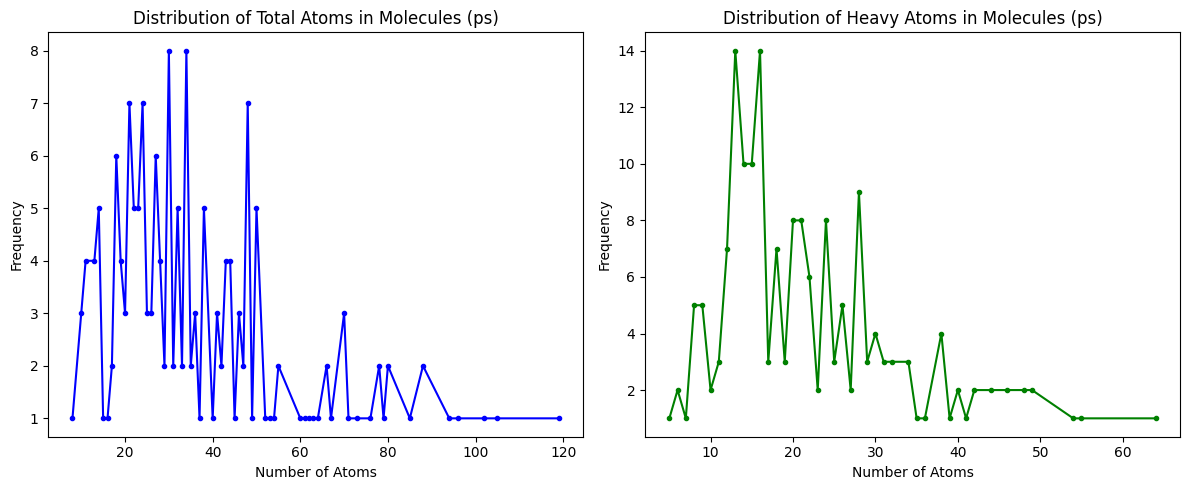

In [25]:
acceptor_total_atoms_counts = acceptor_merged_df['NumAtomsTotal'].value_counts().sort_index()
acceptor_heavy_atoms_counts = acceptor_merged_df['NumAtomsHeavy'].value_counts().sort_index()

# 绘制折线图
plt.figure(figsize=(12, 5))  # 创建一个新图形，并设置尺寸

# 第一个子图：包含所有原子的数量分布
plt.subplot(1, 2, 1)  
plt.plot(acceptor_total_atoms_counts.index, acceptor_total_atoms_counts.values, marker='o', linestyle='-', color='b', markersize=3)
plt.title('Distribution of Total Atoms in Molecules (ps)')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')

# 第二个子图：仅包含非氢原子的数量分布
plt.subplot(1, 2, 2)
plt.plot(acceptor_heavy_atoms_counts.index, acceptor_heavy_atoms_counts.values, marker='o', linestyle='-', color='g', markersize=3)
plt.title('Distribution of Heavy Atoms in Molecules (ps)')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency')

plt.tight_layout()  # 自动调整子图参数，使它们不重叠
plt.show()  # 显示图形

In [26]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.hist(acceptor_merged_df['NumAtomsTotal'], bins=range(min(acceptor_merged_df['NumAtomsTotal']), max(acceptor_merged_df['NumAtomsTotal'])+1))
# plt.title('Distribution of Total Atoms in Molecules (acceptor)')
# plt.xlabel('Number of Atoms')
# plt.ylabel('Frequency')
# # plt.show()

# plt.subplot(1, 2, 2)
# plt.hist(acceptor_merged_df['NumAtomsHeavy'], bins=range(min(acceptor_merged_df['NumAtomsHeavy']), max(acceptor_merged_df['NumAtomsHeavy'])+1))
# plt.title('Distribution of Heavy Atoms in Molecules (acceptor)')
# plt.xlabel('Number of Atoms')
# plt.ylabel('Frequency')


# plt.tight_layout()  # 自动调整子图参数，使它们不重叠
# plt.show()  # 显示图形

### 合并acceptor和ps的特征(rdkit生成)和属性（lifetime）

In [5]:
acceptor_merged_df

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_oxazole,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_pyridine,fr_sulfone,fr_term_acetylene,fr_thiazole,fr_thiophene,fr_unbrch_alkane
0,1,0.577167,acceptor1.sdf,c1ccc(-c2c3ccccc3c(-c3ccccc3)c3c(-c4ccccc4)c4c...,70,42,2.301291,1.226653,2.301291,1.226653,...,0,0,0,0,0,0,0,0,0,0
1,2,0.660066,acceptor2.sdf,c1ccc2cc3cc4ccccc4cc3cc2c1,30,18,2.274907,1.305816,2.274907,1.305816,...,0,0,0,0,0,0,0,0,0,0
2,3,0.591716,acceptor3.sdf,O=C(O)c1c2ccccc2cc2cc3ccccc3cc12,33,21,11.764978,-0.882332,11.764978,0.383197,...,0,0,0,0,0,0,0,0,0,0
3,4,46.709764,acceptor4.sdf,C(#Cc1c2ccccc2c(C#Cc2ccccc2)c2cc3ccccc3cc12)c1...,54,34,3.514479,1.007839,3.514479,1.007839,...,0,0,0,0,0,0,0,0,0,0
4,5,0.000543,acceptor5.sdf,c1ccc2cc3c(-c4ccc(-c5ccc(-c6c7ccccc7cc7cc8cccc...,78,48,2.359988,1.216726,2.359988,1.216726,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,14,12,4.277870,0.058102,4.277870,0.058102,...,0,0,0,0,0,0,0,0,0,0
173,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,26,24,4.484972,0.787037,4.484972,0.787037,...,0,0,0,0,0,0,0,0,0,0
174,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,20,16,4.323810,0.944480,4.323810,0.944480,...,0,0,0,0,0,0,0,0,0,0
175,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,18,16,4.378565,0.583369,4.378565,0.583369,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# 找到两个DataFrame的公共列
common_columns = ps_merged_df.columns.intersection(acceptor_merged_df.columns)
common_columns, len(common_columns)

(Index(['id', 'lifetime', 'Filename', 'SMILES', 'NumAtomsTotal',
        'NumAtomsHeavy', 'MaxEStateIndex', 'MinEStateIndex',
        'MaxAbsEStateIndex', 'MinAbsEStateIndex',
        ...
        'fr_halogen', 'fr_imidazole', 'fr_imide', 'fr_methoxy', 'fr_nitrile',
        'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond',
        'fr_thiophene', 'fr_unbrch_alkane'],
       dtype='object', length=159),
 159)

In [7]:
#  ps列减去公共列，则表示acceptor中没有这些列，那么要判断下这些列是否对Ps很关键，否不应该删除
cols_in_merged_not_in_acceptor = set(ps_merged_df.columns) - set(common_columns)
# 同上
cols_in_acceptor_not_in_ps = set(acceptor_merged_df.columns) - set(common_columns)

In [8]:
cols_in_merged_not_in_acceptor, len(cols_in_merged_not_in_acceptor)

({'NumSaturatedHeterocycles',
  'fr_Al_COO',
  'fr_Imine',
  'fr_Ndealkylation1',
  'fr_aldehyde',
  'fr_amidine',
  'fr_ketone',
  'fr_ketone_Topliss',
  'fr_lactone',
  'fr_nitro',
  'fr_nitro_arom',
  'fr_nitro_arom_nonortho',
  'fr_quatN',
  'fr_sulfonamd'},
 14)

1. NumSaturatedHeterocycles：分子中饱和杂环的数量。重要性：杂环在药物化学和材料科学中具有重要作用，因为它们通常影响分子的物理化学性质和生物活性。
2. fr_Al_COO：分子中带有 -COOH (羧酸) 基团的醛的数量。重要性：羧酸基团常见于有机分子中，具有一定的反应性，影响分子的极性和生物活性。
3. fr_Imine：分子中带有亚胺基（C=N）的数量。重要性：亚胺基团经常出现在化学合成中，它们的存在会影响分子的稳定性和反应性。
4. fr_Ndealkylation1：分子中存在一级 N-去烷基化基团的数量。重要性：去烷基化是代谢过程中常见的反应，特别是在药物代谢研究中有意义。
5. fr_aldehyde：分子中醛基的数量。重要性：醛基团在有机合成和反应性中非常重要，其存在可能影响分子的极性和反应活性。
6. fr_amidine：分子中氨基甲酰胺的数量。重要性：此基团在药物化学中很重要，影响药物与受体的结合性质。
7. fr_ketone：分子中酮基的数量。重要性：酮基在有机分子和反应中经常出现，是一些反应的关键功能团。
8. fr_ketone_Toplis：Toplis描述符，基于拓扑酮的数量。重要性：用于量化分子拓扑性质，特别是在构效关系研究中。
9. fr_lactone：分子中内酯的数量。重要性：内酯在生物化学和药物合成中具有重要意义。
10. fr_nitro：分子中硝基的数量。重要性：硝基影响分子的电子特性，广泛存在于医药化学中。
11. fr_nitro_arom 和 fr_nitro_arom_nonortho：分子中芳香环上的硝基的数量及其非邻位情况。重要性：硝基在芳香化合物中影响电子密度，非邻位可能影响其生物活性和代谢稳定性。
12. fr_quatN：分子中季铵的数量。重要性：季铵基团是极性基团，影响溶解性和生物活性。
13. fr_sulfonamd：分子中磺酰胺基团的数量。重要性：磺酰胺基团是药物分子中常见的基团，具有特殊的生物活性。

In [9]:
cols_in_acceptor_not_in_ps, len(cols_in_acceptor_not_in_ps)

({'fr_furan',
  'fr_oxazole',
  'fr_pyridine',
  'fr_sulfone',
  'fr_term_acetylene',
  'fr_thiazole'},
 6)

1. fr_furan：分子中呋喃环的数量。重要性：呋喃环是芳香杂环化合物，在药物化学中具有广泛应用。
2. fr_oxazole：分子中噁唑环的数量。重要性：噁唑环是一种芳香杂环，常见于药物分子中，具有重要的药理学特性。
3. fr_pyridine：分子中吡啶环的数量。重要性：吡啶是常见的芳香杂环，在许多药物和催化剂中广泛存在。
4. fr_sulfone：分子中磺酮基的数量。重要性：磺酮基团具有高极性和反应性，常用于材料和药物设计。
5. fr_term_acetylene：分子中末端炔烃的数量。重要性：末端炔烃在有机合成和药物设计中常用于交叉偶联反应。
6. fr_thiazole：分子中噻唑环的数量。重要性：噻唑环在药物化学中具有广泛的应用，是多种药物的核心结构。

In [10]:
# 为 acceptor_merged_df 添加 在merged_df 缺失的列，填充为0
for col in cols_in_merged_not_in_acceptor:
    acceptor_merged_df[col] = 0

# 为 ps_merged_df 添加 在acceptor_merged_df 缺失的列，填充为0
for col in cols_in_acceptor_not_in_ps:
    ps_merged_df[col] = 0

# 合并两个 DataFrame
combined_df = pd.concat([ps_merged_df, acceptor_merged_df], ignore_index=True)

# 查看合并后的 DataFrame
combined_df   # 159+14+6=179列

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_quatN,fr_sulfonamd,fr_thiophene,fr_unbrch_alkane,fr_furan,fr_term_acetylene,fr_sulfone,fr_thiazole,fr_pyridine,fr_oxazole
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,12,6,9.793981,-0.379630,9.793981,0.379630,...,0,0,0,0,0,0,0,0,0,0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,24,20,11.997107,-0.021721,11.997107,0.021721,...,0,0,0,0,0,0,0,0,0,0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,22,12,10.377891,0.571389,10.377891,0.571389,...,0,0,0,0,0,0,0,0,0,0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,24,16,12.101296,-0.064074,12.101296,0.064074,...,0,0,0,0,0,0,0,0,0,0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,21,11,10.945093,0.030046,10.945093,0.030046,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,14,12,4.277870,0.058102,4.277870,0.058102,...,0,0,0,0,0,0,0,0,0,0
359,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,26,24,4.484972,0.787037,4.484972,0.787037,...,0,0,0,0,0,0,0,0,0,0
360,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,20,16,4.323810,0.944480,4.323810,0.944480,...,0,0,0,0,0,0,0,0,0,0
361,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,18,16,4.378565,0.583369,4.378565,0.583369,...,0,0,0,0,0,0,0,0,0,0


In [11]:
combined_df[combined_df['NumAtomsTotal'] == 134]

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,fr_quatN,fr_sulfonamd,fr_thiophene,fr_unbrch_alkane,fr_furan,fr_term_acetylene,fr_sulfone,fr_thiazole,fr_pyridine,fr_oxazole
137,193,0.402091,ps193.sdf,CC1(C)Cc2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)cc5C(=O...,134,58,14.666155,-0.267587,14.666155,0.024563,...,4,0,0,0,0,0,0,0,0,0


In [12]:
max_atoms_row = combined_df.index[combined_df['NumAtomsTotal'] == 134]
max_atoms_id = combined_df.loc[max_atoms_row]['id'].values  # 获取分子编号,即193号分子
max_atoms_id    # 193号分子的原子总数最大，134

array([193], dtype=int64)

#### ----------------------------------------- 以上是ps-df分别删除了全0列后进行合并，分子新增的列数值设为0 ------------------------------------------

### 将上述combined_df与上三角且去除全0列后的CM_df进行合并，然后再一起降维 

##### 先处理ps和acceptor的CM_df；因为最终二者是放在一起训练的，因此应将二者合并建立一个新的CM

In [17]:
ps_total_atoms_counts = ps_merged_df['NumAtomsTotal'].value_counts().sort_index()
ps_heavy_atoms_counts = ps_merged_df['NumAtomsHeavy'].value_counts().sort_index()

In [18]:
min(ps_total_atoms_counts.index), max(ps_total_atoms_counts.index), min(ps_heavy_atoms_counts.index), max(ps_heavy_atoms_counts.index)

(7, 134, 5, 76)

In [19]:
acceptor_total_atoms_counts = acceptor_merged_df['NumAtomsTotal'].value_counts().sort_index()
acceptor_heavy_atoms_counts = acceptor_merged_df['NumAtomsHeavy'].value_counts().sort_index()

In [20]:
min(acceptor_total_atoms_counts.index), max(acceptor_total_atoms_counts.index), min(acceptor_heavy_atoms_counts.index), max(acceptor_heavy_atoms_counts.index)

(8, 119, 5, 64)

In [21]:
def GetCM(sdf_file_folder:str,csv_file:str, atoms_max:int):
    sdf_files = glob.glob(sdf_file_folder+'\*.sdf')
    cm_init = CoulombMatrix(n_atoms_max=atoms_max)
    cm_array = []
    molecule_ids = []  # 用于存储文件名中的分子编号
    filenames = []   # 存储文件名
    
    for sdf_file in sdf_files:
        # 只获取文件名，不包括路径，os.path.basename可以处理不同操作系统的路径分隔符（如 Windows 的 \ 和 Unix 的 /）
        filename = os.path.basename(sdf_file) 
#         filename = sdf_file.split('\\')[-1]   # 仅适用于 Windows 路径分隔符 \
        if 'ps' in filename:
            molecule_id = int(filename.split('ps')[1].split('.sdf')[0])
        elif 'acceptor' in filename:
            molecule_id = int(filename.split('acceptor')[1].split('.sdf')[0])
        else:
            print(f"{sdf_file}格式有问题")
            # 如果文件名不符合上述格式，可以选择跳过或引发错误
            continue
        
        # 提取文件名中的分子编号，假设文件名格式为 psXXX.sdf
        molecule_ids.append(molecule_id)
        filenames.append(filename)
        
        # 读取分子结构并计算库仑矩阵
        tmp_atoms = io.read(sdf_file,format='sdf')
        tmp_cm = list(cm_init.create(tmp_atoms))
        cm_array.append(tmp_cm)
    
    # 转换为 numpy 数组
    cm_array = np.array(cm_array)
    
    # 创建列名
    columns_num = cm_array.shape[1]
    columns = ["CM_%d" % i for i in range(columns_num)]
    
    # 创建 DataFrame 并在第一列插入分子编号
    cm_df = pd.DataFrame(cm_array, columns=columns)
    cm_df.insert(0, 'id', molecule_ids)  # 在第一列插入分子编号
    cm_df.insert(1, 'Filename', filenames)  # 在第一列插入分子编号
    
#     cm_df.to_csv(csv_file)
    return cm_df

In [22]:
all_sdf_file_path = r'C:\Users\xiaoyu\Desktop\click\molecule_Structure_ChemDraw\all_sdf'
cm_df = GetCM(all_sdf_file_path, None, max(ps_total_atoms_counts.index))
cm_df

,id,Filename,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,...,CM_17946,CM_17947,CM_17948,CM_17949,CM_17950,CM_17951,CM_17952,CM_17953,CM_17954,CM_17955
0,1,acceptor1.sdf,36.858105,43.636364,43.635033,25.193210,43.635033,25.193210,25.194205,21.818662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,acceptor10.sdf,73.516695,9.079552,11.082251,44.787929,7.706366,58.180044,8.068380,33.592274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,acceptor100.sdf,73.516695,44.789497,58.186152,33.592274,16.796137,16.137170,21.990788,29.091549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101,acceptor101.sdf,73.516695,44.787929,58.180044,58.181818,33.590947,29.090022,21.990564,33.589923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,102,acceptor102.sdf,73.516695,11.082570,44.787929,11.830590,58.180044,9.316892,10.995641,33.592274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,95,ps95.sdf,53.358707,22.739272,65.707084,23.600104,10.511927,16.738083,13.136941,11.910326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,96,ps96.sdf,73.516695,25.689413,24.312542,12.939168,13.251440,33.643528,44.788566,13.550983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450,97,ps97.sdf,53.358707,65.707084,22.739272,23.600104,16.738083,13.136941,10.511927,11.910326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,98,ps98.sdf,36.858105,93.504757,10.995206,13.876808,114.829568,11.133559,10.188225,8.920976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
'''对比批量生成CM和单独生成的CM是否有差异（针对193号分子）-》从生成的CM矩阵中获取分子193的库伦矩阵，
同时又单独计算分子193的CM，二者中为0的数值确实是一样的（因为193号分子为CM函数设置的134个原子，没有空的原子数，
所以理论上193中的134个原子相互作用不为0）'''
# 根据id从批量生成的cm_df中获得分子193的库伦矩阵
molecule_193_df = cm_df[cm_df['id'] == 193]    
# 找到值为 193号分子相互作用为0 的列名
zero_columns = molecule_193_df.loc[:, (molecule_193_df == 0).all()].columns
# print(molecule_193_df)
zero_columns, len(zero_columns)

(Index(['CM_58', 'CM_59', 'CM_60', 'CM_61', 'CM_62', 'CM_63', 'CM_64', 'CM_65',
        'CM_66', 'CM_67',
        ...
        'CM_17946', 'CM_17947', 'CM_17948', 'CM_17949', 'CM_17950', 'CM_17951',
        'CM_17952', 'CM_17953', 'CM_17954', 'CM_17955'],
       dtype='object', length=14592),
 14592)

In [24]:
# 单独读取分子并计算库仑矩阵
from ase.io import read
molecule_193 = read(r'C:\Users\xiaoyu\Desktop\click\molecule_Structure_ChemDraw\all_sdf\ps193.sdf', format='sdf')
cm_init = CoulombMatrix(n_atoms_max=134)
cm = cm_init.create(molecule_193)
cm_array = np.array(cm)

# 计算零值的数量
num_zeros = np.sum(cm_array == 0)
num_zeros

14592

In [25]:
'''但实际上，根据上述对批量生成193CM和单独生成193CM的对比，二则均存在大量相互作用为0的点，且数量已知，因此没有算错'''

'但实际上，根据上述对批量生成193CM和单独生成193CM的对比，二则均存在大量相互作用为0的点，且数量已知，因此没有算错'

##### 对生成的库伦矩阵进行上三角展开降维

In [26]:
# 获取上三角的索引，包括对角线
n_atoms_max = int(np.sqrt(cm_df.shape[1]))  # 假设库仑矩阵最大的原子数，134

# 得到行索引row和列索引col，这样就可以在二维数组中定位数据了，但是我们得到的是CM的一维序列
upper_triangle_indices = np.triu_indices(n_atoms_max) 

# 将上三角的二维索引转换为一维索引
'''根据这个公式：linear_index = row×n+col，将二维索引转换为一维索引，这里n = n_atoms_max'''
flattened_upper_triangle_indices = np.ravel_multi_index(upper_triangle_indices, (n_atoms_max, n_atoms_max))

# 提取上三角元素对应的列名
upper_triangle_column_names = [f"CM_{i}" for i in flattened_upper_triangle_indices]
upper_triangle_indices, len(upper_triangle_column_names)

((array([  0,   0,   0, ..., 132, 132, 133]),
  array([  0,   1,   2, ..., 132, 133, 133])),
 9045)

In [27]:
upper_triangle_column_names = ['id', 'Filename'] + upper_triangle_column_names
len(upper_triangle_column_names)

9047

In [28]:
# 经过上三角降维的CM矩阵
upper_triangle_cm_df = cm_df[upper_triangle_column_names]
upper_triangle_cm_df   # n*(n+1)/2

,id,Filename,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,...,CM_17550,CM_17551,CM_17552,CM_17553,CM_17685,CM_17686,CM_17687,CM_17820,CM_17821,CM_17955
0,1,acceptor1.sdf,36.858105,43.636364,43.635033,25.193210,43.635033,25.193210,25.194205,21.818662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,acceptor10.sdf,73.516695,9.079552,11.082251,44.787929,7.706366,58.180044,8.068380,33.592274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,acceptor100.sdf,73.516695,44.789497,58.186152,33.592274,16.796137,16.137170,21.990788,29.091549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101,acceptor101.sdf,73.516695,44.787929,58.180044,58.181818,33.590947,29.090022,21.990564,33.589923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,102,acceptor102.sdf,73.516695,11.082570,44.787929,11.830590,58.180044,9.316892,10.995641,33.592274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,95,ps95.sdf,53.358707,22.739272,65.707084,23.600104,10.511927,16.738083,13.136941,11.910326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,96,ps96.sdf,73.516695,25.689413,24.312542,12.939168,13.251440,33.643528,44.788566,13.550983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450,97,ps97.sdf,53.358707,65.707084,22.739272,23.600104,16.738083,13.136941,10.511927,11.910326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,98,ps98.sdf,36.858105,93.504757,10.995206,13.876808,114.829568,11.133559,10.188225,8.920976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
cols_to_drop = upper_triangle_cm_df.columns[upper_triangle_cm_df.sum() == 0]
cols_to_drop, len(cols_to_drop)

(Index(['CM_110', 'CM_111', 'CM_112', 'CM_113', 'CM_114', 'CM_115', 'CM_116',
        'CM_117', 'CM_118', 'CM_119',
        ...
        'CM_17550', 'CM_17551', 'CM_17552', 'CM_17553', 'CM_17685', 'CM_17686',
        'CM_17687', 'CM_17820', 'CM_17821', 'CM_17955'],
       dtype='object', length=2940),
 2940)

In [30]:
# 检查cols_to_drop的每一列是否全为零
zero_columns = upper_triangle_cm_df[cols_to_drop].apply(lambda col: (col == 0).all())
zero_columns, len(zero_columns)
all_columns_zero = zero_columns.all()
all_columns_zero

True

In [31]:
# 删除所有全为零的列
upper_triangle_cm_df = upper_triangle_cm_df.drop(columns=cols_to_drop)
upper_triangle_cm_df

,id,Filename,CM_0,CM_1,CM_2,CM_3,CM_4,CM_5,CM_6,CM_7,...,CM_14310,CM_14311,CM_14312,CM_14313,CM_14445,CM_14446,CM_14447,CM_14580,CM_14581,CM_14715
0,1,acceptor1.sdf,36.858105,43.636364,43.635033,25.193210,43.635033,25.193210,25.194205,21.818662,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,acceptor10.sdf,73.516695,9.079552,11.082251,44.787929,7.706366,58.180044,8.068380,33.592274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,acceptor100.sdf,73.516695,44.789497,58.186152,33.592274,16.796137,16.137170,21.990788,29.091549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,101,acceptor101.sdf,73.516695,44.787929,58.180044,58.181818,33.590947,29.090022,21.990564,33.589923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,102,acceptor102.sdf,73.516695,11.082570,44.787929,11.830590,58.180044,9.316892,10.995641,33.592274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,95,ps95.sdf,53.358707,22.739272,65.707084,23.600104,10.511927,16.738083,13.136941,11.910326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
449,96,ps96.sdf,73.516695,25.689413,24.312542,12.939168,13.251440,33.643528,44.788566,13.550983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450,97,ps97.sdf,53.358707,65.707084,22.739272,23.600104,16.738083,13.136941,10.511927,11.910326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,98,ps98.sdf,36.858105,93.504757,10.995206,13.876808,114.829568,11.133559,10.188225,8.920976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# 检查一列是否全为0
is_column_all_zero = (upper_triangle_cm_df['CM_14311'] == 0).all()  
is_column_all_zero

False

#### 合并上三角的CM和rdkit描述符

In [33]:
ids_are_equal = combined_df['id'].equals(upper_triangle_cm_df['id'])  # 二者肯定不一样，因为CM是所有的SDF得到，combined_df是算出lifetime的数据集
print(ids_are_equal)

False


In [34]:
len(combined_df), len(upper_triangle_cm_df)

(363, 453)

In [35]:
a = sorted(combined_df['Filename'].values)
b = sorted(upper_triangle_cm_df['Filename'].values)
diff_a_not_in_b = set(a) - set(b)  # 仅在 `a` 中的项
diff_b_not_in_a = set(b) - set(a)
diff_a_not_in_b  # set()
# len(diff_b_not_in_a), diff_b_not_in_a,

set()

##### 基于FileName合并，combined_df与CM_df

In [36]:
final_combined_df = pd.merge(combined_df, upper_triangle_cm_df, on='Filename', how='inner')
'''199.sdf和200.sdf没法正常读取，没有相应的描述符,因此少两个'''
final_combined_df  

,id_x,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,CM_14310,CM_14311,CM_14312,CM_14313,CM_14445,CM_14446,CM_14447,CM_14580,CM_14581,CM_14715
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,12,6,9.793981,-0.379630,9.793981,0.379630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,24,20,11.997107,-0.021721,11.997107,0.021721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,22,12,10.377891,0.571389,10.377891,0.571389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,24,16,12.101296,-0.064074,12.101296,0.064074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,21,11,10.945093,0.030046,10.945093,0.030046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,14,12,4.277870,0.058102,4.277870,0.058102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,26,24,4.484972,0.787037,4.484972,0.787037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,20,16,4.323810,0.944480,4.323810,0.944480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,18,16,4.378565,0.583369,4.378565,0.583369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# 使用合并后的 'Filename' 列从原始数据框中提取对应的 'id' 列
id_combined = combined_df.set_index('Filename').loc[final_combined_df['Filename'], 'id'].reset_index(drop=True)
id_upper_triangle = upper_triangle_cm_df.set_index('Filename').loc[final_combined_df['Filename'], 'id'].reset_index(drop=True)
ids_are_equal = id_combined.equals(id_upper_triangle)

In [38]:
ids_are_equal

True

In [39]:
a = final_combined_df['id_x']== final_combined_df['id_y']
(a == True).all()  # 所有值都相同

True

In [40]:
if ids_are_equal:
    # 如果相同，只保留一个id列
    final_combined_df.drop(columns=['id_y'], inplace=True)
    final_combined_df.rename(columns={'id_x': 'id'}, inplace=True)
else:
    print("ID列不相同，进一步处理。")

In [41]:
final_combined_df

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,CM_14310,CM_14311,CM_14312,CM_14313,CM_14445,CM_14446,CM_14447,CM_14580,CM_14581,CM_14715
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,12,6,9.793981,-0.379630,9.793981,0.379630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,24,20,11.997107,-0.021721,11.997107,0.021721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,22,12,10.377891,0.571389,10.377891,0.571389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,24,16,12.101296,-0.064074,12.101296,0.064074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,21,11,10.945093,0.030046,10.945093,0.030046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,14,12,4.277870,0.058102,4.277870,0.058102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,26,24,4.484972,0.787037,4.484972,0.787037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,20,16,4.323810,0.944480,4.323810,0.944480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,18,16,4.378565,0.583369,4.378565,0.583369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### 查找nan值

In [42]:
# 检查 NaN 值的总数
nan_count = final_combined_df.isna().sum()

# 找出存在 NaN 值的列
nan_columns = nan_count[nan_count > 0]

# 打印存在 NaN 值的列及其数量
print(f"Columns with NaN values and their counts:\n{nan_columns}")

# 找出含有NaN值的行索引
nan_rows = final_combined_df[final_combined_df.isna().any(axis=1)]

Columns with NaN values and their counts:
MaxPartialCharge       4
MinPartialCharge       4
MaxAbsPartialCharge    4
MinAbsPartialCharge    4
BCUT2D_MWHI            4
BCUT2D_MWLOW           4
BCUT2D_CHGHI           4
BCUT2D_CHGLO           4
BCUT2D_LOGPHI          4
BCUT2D_LOGPLOW         4
BCUT2D_MRHI            4
BCUT2D_MRLOW           4
dtype: int64


In [43]:
nan_rows.loc[nan_rows.index, nan_columns.index]

,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# 将所有 NaN 值替换为 0
final_combined_df = final_combined_df.fillna(0)

final_combined_df.loc[nan_rows.index]  # 原来的NAN均填充为0

final_combined_df[final_combined_df.isna().any(axis=1)]  # 检查是否还存在nan

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,CM_14310,CM_14311,CM_14312,CM_14313,CM_14445,CM_14446,CM_14447,CM_14580,CM_14581,CM_14715


###### 处理完再次检查nan值

In [45]:
# 再次检查是否存在 NaN
nan_check = final_combined_df.isna().any().sum()
nan_check

0

##### 检查非数值类型

In [46]:
final_combined_df

,id,lifetime,Filename,SMILES,NumAtomsTotal,NumAtomsHeavy,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,CM_14310,CM_14311,CM_14312,CM_14313,CM_14445,CM_14446,CM_14447,CM_14580,CM_14581,CM_14715
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,12,6,9.793981,-0.379630,9.793981,0.379630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,24,20,11.997107,-0.021721,11.997107,0.021721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,22,12,10.377891,0.571389,10.377891,0.571389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,24,16,12.101296,-0.064074,12.101296,0.064074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,21,11,10.945093,0.030046,10.945093,0.030046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,14,12,4.277870,0.058102,4.277870,0.058102,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,26,24,4.484972,0.787037,4.484972,0.787037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,20,16,4.323810,0.944480,4.323810,0.944480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,18,16,4.378565,0.583369,4.378565,0.583369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# 检查非数值列
non_numeric_columns = final_combined_df.drop(columns=['Filename', 'SMILES']).select_dtypes(exclude=[np.number]).columns
print(f"Non-numeric columns: {non_numeric_columns}")   # 188+226=414

Non-numeric columns: Index([], dtype='object')


##### 处理无穷大或无穷小

In [48]:
# 检查是否包含无穷大或 NaN 值
inf_values = final_combined_df.isin([np.inf, -np.inf]).sum().sum()
nan_values = final_combined_df.isna().sum().sum()
inf_values

2

In [49]:
# 筛选出包含无穷大（inf）或无穷小（-inf）值的行索引
inf_rows = final_combined_df[(final_combined_df == np.inf) | (final_combined_df == -np.inf)].any(axis=1)

# 仅返回存在无穷大或无穷小值的行信息
inf_rows_info = {idx: final_combined_df.loc[idx, final_combined_df.loc[idx].isin([np.inf, -np.inf])].index.tolist() for idx in inf_rows.index if inf_rows[idx]}

# 输出结果
inf_rows_info

{210: ['CM_1', 'CM_271']}

In [50]:
final_combined_df.loc[209,['Filename', 'CM_1', 'CM_271']]

Filename    acceptor26.sdf
CM_1             21.818182
CM_271           25.192442
Name: 209, dtype: object

In [51]:
# from sklearn.impute import KNNImputer
# import numpy as np

# # 1. 将 inf 替换为 NaN
# final_combined_df[['CM_1', 'CM_271']] = final_combined_df[['CM_1', 'CM_271']].replace([np.inf, -np.inf], np.nan)

# # 2. 使用 KNNImputer 进行填补
# knn_imputer = KNNImputer(n_neighbors=5)
# final_combined_df[['CM_1', 'CM_271']] = knn_imputer.fit_transform(final_combined_df[['CM_1', 'CM_271']])

# # 3. 查看填补后的结果
# print(final_combined_df.loc[209, ['CM_1', 'CM_271']])

In [52]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import numpy as np

# 1. 将 inf 替换为 NaN
final_combined_df[['CM_1', 'CM_271']] = final_combined_df[['CM_1', 'CM_271']].replace([np.inf, -np.inf], np.nan)

# 2. 使用 IterativeImputer 进行填补
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
final_combined_df[['CM_1', 'CM_271']] = iterative_imputer.fit_transform(final_combined_df[['CM_1', 'CM_271']])

# 3. 查看填补后的结果
print(final_combined_df.loc[209, ['CM_1', 'CM_271']])

CM_1      21.818182
CM_271    25.192442
Name: 209, dtype: object


In [53]:
# max_value = final_combined_df.drop(columns=['Filename', 'SMILES']).replace([np.inf, -np.inf], np.nan).max().max()
# max_value

In [54]:
final_combined_df.loc[209,['Filename', 'CM_1', 'CM_271']]

Filename    acceptor26.sdf
CM_1             21.818182
CM_271           25.192442
Name: 209, dtype: object

In [55]:
# 再次检查 是否包含无穷大或 NaN 值
inf_values = final_combined_df.isin([np.inf, -np.inf]).sum().sum()
nan_values = final_combined_df.isna().sum().sum()
inf_values, nan_values

(0, 0)

##### person相关性降维

In [56]:
# 计算特征和目标属性的相关性
target_corr = final_combined_df.corrwith(final_combined_df['lifetime']).abs()

In [57]:
# 计算所有特征之间的相关性矩阵
corr_matrix = final_combined_df.corr().abs()

# 提取上三角部分
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

In [58]:
# 找到相关性大于阈值的特征对
high_corr_pairs = []
for column in upper_triangle.columns:
    high_corr = upper_triangle[column][upper_triangle[column] > 0.95]
    high_corr_pairs.extend([(column, index) for index in high_corr.index])

In [59]:
# 保留与目标属性 'lifetime' 相关性更高的特征
features_to_drop = set()
for col1, col2 in high_corr_pairs:
    if col1 in features_to_drop or col2 in features_to_drop:
        continue
    if target_corr[col1] > target_corr[col2]:
        features_to_drop.add(col2)
    else:
        features_to_drop.add(col1)

# 删除冗余特征
final_combined_df_cleaned = final_combined_df.drop(columns=features_to_drop)

print(f"Removed {len(features_to_drop)} highly correlated features with less correlation to the target.")

Removed 1322 highly correlated features with less correlation to the target.


In [60]:
len(features_to_drop)

1322

In [61]:
final_combined_df_cleaned

,id,lifetime,Filename,SMILES,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,HeavyAtomMolWt,MaxPartialCharge,...,CM_14310,CM_14311,CM_14312,CM_14313,CM_14445,CM_14446,CM_14447,CM_14580,CM_14581,CM_14715
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,9.793981,-0.379630,0.379630,0.425942,80.042,0.194514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,11.997107,-0.021721,0.021721,0.263082,711.756,0.208513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,10.377891,0.571389,0.571389,0.638385,156.096,0.160927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,12.101296,-0.064074,0.064074,0.568337,200.152,0.194013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,10.945093,0.030046,0.030046,0.601659,140.097,0.163022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,4.277870,0.058102,0.058102,0.580195,286.014,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,4.484972,0.787037,0.787037,0.404248,384.456,0.114650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,4.323810,0.944480,0.944480,0.477024,240.272,0.112190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,4.378565,0.583369,0.583369,0.476945,244.264,0.212617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 保存最终的数据集，其合并了rdikit描述符、属性值，库伦矩阵，并去除了一些nan值、inf值、字符值等，最终可以用于预测dataframe

In [62]:
# save final combined csv file
final_combined_df_cleaned_fp = r'data\final_combined_df_cleaned.csv'
final_combined_df_cleaned.to_csv(final_combined_df_cleaned_fp, index=False)

In [16]:
# load final combined csv file
final_combined_df_cleaned_fp = r'data\final_combined_df_cleaned.csv'
final_combined_df_cleaned = pd.read_csv(final_combined_df_cleaned_fp)
final_combined_df_cleaned

,id,lifetime,Filename,SMILES,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,HeavyAtomMolWt,MaxPartialCharge,...,CM_14310,CM_14311,CM_14312,CM_14313,CM_14445,CM_14446,CM_14447,CM_14580,CM_14581,CM_14715
0,1,0.009525,ps1.sdf,CC(=O)C(C)=O,9.793981,-0.379630,0.379630,0.425942,80.042,0.194514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.001015,ps2.sdf,O=c1c(I)cc2cc3cc(I)c(O)c(I)c3oc-2c1I,11.997107,-0.021721,0.021721,0.263082,711.756,0.208513,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.027435,ps3.sdf,COc1ccc(C=O)cc1OC,10.377891,0.571389,0.571389,0.638385,156.096,0.160927,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.001420,ps4.sdf,O=C1c2ccccc2C(=O)c2ccccc21,12.101296,-0.064074,0.064074,0.568337,200.152,0.194013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.000101,ps5.sdf,COc1ccccc1C(C)=O,10.945093,0.030046,0.030046,0.601659,140.097,0.163022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,201,0.003018,acceptor201.sdf,c1c2c(cc3n[se]nc13)N=[Se]=N2,4.277870,0.058102,0.058102,0.580195,286.014,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,202,22.406453,acceptor202.sdf,c1c2c(c(-c3c4c(cc5nsnc35)N=S=N4)c3nsnc13)N=S=N2,4.484972,0.787037,0.787037,0.404248,384.456,0.114650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
360,203,0.811030,acceptor203.sdf,c1cc2c(ccc3nsnc32)c2nsnc12,4.323810,0.944480,0.944480,0.477024,240.272,0.112190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
361,204,0.092019,acceptor204.sdf,c1c2c(cc3nc4nsnc4nc13)N=S=N2,4.378565,0.583369,0.583369,0.476945,244.264,0.212617,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X_filled = final_combined_df_cleaned.drop(['lifetime', 'id', 'Filename', 'SMILES'], axis=1)
y = final_combined_df_cleaned['lifetime']
X_filled.shape, y.shape

((363, 4958), (363,))

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
X_train, X_test= train_test_split(X_filled, test_size=0.1, random_state=1)
y_train, y_test = train_test_split(y, test_size=0.1, random_state=1)

#### 分离目标属性和特征, 直接进行预测

In [68]:
# 初始化并训练随机森林回归模型
model = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=666)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=300, random_state=666)

In [69]:
# 对测试集进行预测
y_pred = model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

# 如果需要对整个数据集进行预测：
# y_pred_all = model.predict(X)

Mean Squared Error (MSE): 73644.28305559879
R^2 Score: 0.011781521238868109


#### 随机森林拟合，获取特征重要性排序

In [8]:
model = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=1)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=300, random_state=1)

In [9]:
# 获取特征的重要性
feature_importances = model.feature_importances_

In [10]:
# 设置一个阈值，删除低于该阈值的重要性特征
importance_threshold = 0.01 # 根据实际情况调整  # 0.005/33/0.02   0.01/33
important_features = np.array(X_filled.columns)[feature_importances > importance_threshold]
important_features, len(important_features)

(array(['MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex',
        'MaxPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MRLOW', 'CM_143',
        'CM_409', 'CM_676', 'CM_683', 'CM_826', 'CM_1354', 'CM_1891'],
       dtype=object),
 13)

In [11]:
# 保留重要的特征
X_reduced = X_filled[important_features]

# 更新 DataFrame
final_combined_df_reduced = X_reduced.copy()
final_combined_df_reduced['lifetime'] = y
final_combined_df_reduced

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MaxPartialCharge,BCUT2D_MWHI,BCUT2D_MRLOW,CM_143,CM_409,CM_676,CM_683,CM_826,CM_1354,CM_1891,lifetime
0,9.793981,-0.379630,0.379630,0.194514,16.171947,-0.133537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009525
1,11.997107,-0.021721,0.021721,0.208513,126.915758,0.466066,97.125979,63.368295,9.522366,16.493091,0.000000,21.990788,14.545520,0.001015
2,10.377891,0.571389,0.571389,0.160927,16.507769,0.111797,14.545455,19.393939,43.635033,0.000000,0.000000,0.000000,0.000000,0.027435
3,12.101296,-0.064074,0.064074,0.194013,16.144174,0.097888,16.795767,43.635033,21.817517,21.818662,0.000000,9.522366,43.636364,0.001420
4,10.945093,0.030046,0.030046,0.163022,16.466034,0.101012,19.394027,25.194205,14.545520,0.000000,0.000000,0.000000,0.000000,0.000101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,4.277870,0.058102,0.058102,0.000000,0.000000,0.000000,152.827791,50.911104,18.849061,0.000000,0.000000,0.000000,0.000000,0.003018
359,4.484972,0.787037,0.787037,0.114650,32.142175,1.495429,31.580750,59.844758,16.343139,16.051677,13.863664,14.786577,25.192442,22.406453
360,4.323810,0.944480,0.944480,0.112190,32.141875,1.651758,71.912172,14.323555,31.464592,15.216885,0.000000,21.818182,12.103014,0.811030
361,4.378565,0.583369,0.583369,0.212617,32.140758,1.339437,23.143897,23.164396,14.909516,18.849061,0.000000,43.639614,21.818182,0.092019


#### 在检查是否有nan和Inf数值

In [12]:
inf_values = X_reduced.isin([np.inf, -np.inf]).sum().sum()
nan_values = X_reduced.isna().sum().sum()
inf_values, nan_values

(0, 0)